Tommaso Peritore

In [50]:
#import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True' #This is needed in my Anaconda+MacOsX installation; leave it commented.

import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers.legacy import SGD, Adam, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam

import os
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display, clear_output
import time

seed=0
np.random.seed(seed) # fix random seed
tf.random.set_seed(seed)

colors = ['#274001', '#828a00', '#f29f05', '#f25c05', '#d6568c', '#4d8584', '#a62f03', '#400d01', '#8a2f00', '#d6a05e']

# 12.1

Change at will and train your DNN by increasing the number of epochs to an adequate value. Try to use at least two other optimizers, different from SGD: watch the accuracy and loss for training and validation data and comment on the performances.

## Solution

### Premises 
The problem we are dealing with is the classification of the MNIST dataset. It is a dataset of handwritten digits, from $0$ to $9$, and it is a well-known dataset in the machine learning world. The digits come as a square image, divided into a $28\times 28$ pixel grid. For each pixel we are given the value of gray it assumes, ranging from white to bllack, i.e. from $0$ to $255$. 

The code needed to build the Deep Neural Network (DNN) was already provided in the exercise text. I will start from that code and then modify the number of epochs and the optimizer to find a satisfying combination of parameters. 

I will set the number of epochs to a high number, in order to allow the model to train for a longer time. From the plots of the loss in function of the epochs, I will be able to see when the model reaches a plateau and stops improving.

On the other hand, for the optimizers, I will explore a few, listed below for use in the code.

In [51]:
# Exploring variations

trial_optimizers = [SGD, RMSprop, Adagrad, Adam, Nadam]
trial_optimizers_names = ['SGD', 'RMSprop', 'Adagrad', 'Adam', 'Nadam']


### Data import and formatting
`Keras` has the ability to easily download the MNIST data from the web. To do this, in the box at the beginning of the exercise I've imported the `mnist` module and I will use the `load_data` method, and the training and test data set will be generated.

Unlike for previous exercises, we don't need to provided the number of training and testind data, as MNIST has predefined test and training sets, in order to facilitate the comparison of the performance of different models on the data.
<br> Once loaded, the data needs proper formatting to be used in the DNN. The images are 28x28 pixels, and the pixel values are in the range [0, 255]. I will normalize the pixel values to be in the range [0, 1] by dividing by 255. Finally, I will turn the output data to categorical, as the output of the DNN will be a probability distribution over the 10 classes.

In [52]:
# input image dimensions
img_rows, img_cols = 28, 28 # number of pixels 
# output
num_classes = 10 # 10 digits

# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# reshape data, it could depend on Keras backend
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
#print('Before to_categorical: ')
#print('X_train shape:', X_train.shape)
#print('X_test shape:', X_test.shape)

# cast floats to single precision, and rescale to interval [0,1]
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)
#print('After to_categorical: ')
#print('X_train shape:', X_train.shape)
#print('Y_train shape:', Y_train.shape)

### Network initialization
Now we are ready to initialize the network. Through the Sequential class of Keras, I will instantiate a model and gradually add different layers using the _add_ method. 
I will use the same architecture as in the exercise text, with 2 hidden layers of 400 and 100 neurons, respectively. For the first layer we need to specify the input shape, which is the number of pixels in the images from MNIST, i.e. $28\times 28 = 784$. 

The activation function will be `relu` for the hidden layers and `softmax` for the output layer. The latter is a function known as normalized exponential. It takes as input a vector of K real numbers and normalizes it into a probability distribution consisting of K probabilities. Thus the input could have components with negative values or values greater than one, and the sum of the components might not equal 1. With the application of softmax, each component will be in the interval $[0, 1]$ and the sum of the components will be 1, so that they can be interpreted as probabilities.

The loss function will be `categorical_crossentropy`, as we are dealing with a classification problem. The optimizer will be one of the ones listed below.

Before the output layer, in the construction of the network we used the `Dropout` layer. This is a regularization technique that helps to prevent overfitting during training. It works by randomly setting a fraction of input units to 0 (effectively disabling random neurons) at each update during training time to reduce interdependence of different neurons. This might have a hit on accuracy during training, but it forces the model to learn the more substantial features of the data, improving generalization. 

Of course the dropout layer is not used during testing, as we want to use all the neurons to make predictions. This allows the model to benefit from all the weak classifiers present in the neural network, which have been trained with different subsets of the data (subset of active neurons) during training. As a result, the accuracy during testing can improve compared to training, as the model can effectively combine the predictions of all the weak classifiers to get better results on new data that have not been used during training.

In [53]:
def create_DNN():
   # instantiate model
   model = Sequential()
   # add a dense all-to-all relu layer
   model.add(Dense(400,input_shape=(img_rows*img_cols,), activation='relu'))
   # add a dense all-to-all relu layer
   model.add(Dense(100, activation='relu'))
   # apply dropout with rate 0.5
   model.add(Dropout(0.5))
   # soft-max layer
   model.add(Dense(num_classes, activation='softmax'))
   
   return model

print('Model architecture created successfully!')

Model architecture created successfully!


### Model compiling
For classification problems such as this one, the cross entropy is the best loss function. Since the output data is converted to the _categorical format_, we choose the `categorical_crossentropy` function defined in the `losses` module of Keras.

Note how easy it is to call for the optimizers simply through their names. As said before I am comparing results with multiple optimizers and the `compile_model` function takes as input an integer that will be used to select the optimizer.

In [54]:
def compile_model(int_optimizers):
   # create the model
   model = create_DNN()
   # compile the model
   optimizer = trial_optimizers[int_optimizers]()
   model.compile( loss=keras.losses.categorical_crossentropy,
                  optimizer=optimizer,
                  metrics=['acc'])
   return model

print('Model compiled successfully and ready to be trained.')

Model compiled successfully and ready to be trained.


### Network training and evaluation
Finally here we train and evaluate the model in a cycle to use all the optimizers and compare the results. The training is done with the `fit` method, which will run for a number of epochs, were within each one the training data is divided into batches that get redrawn from reshuffled data at each epoch.

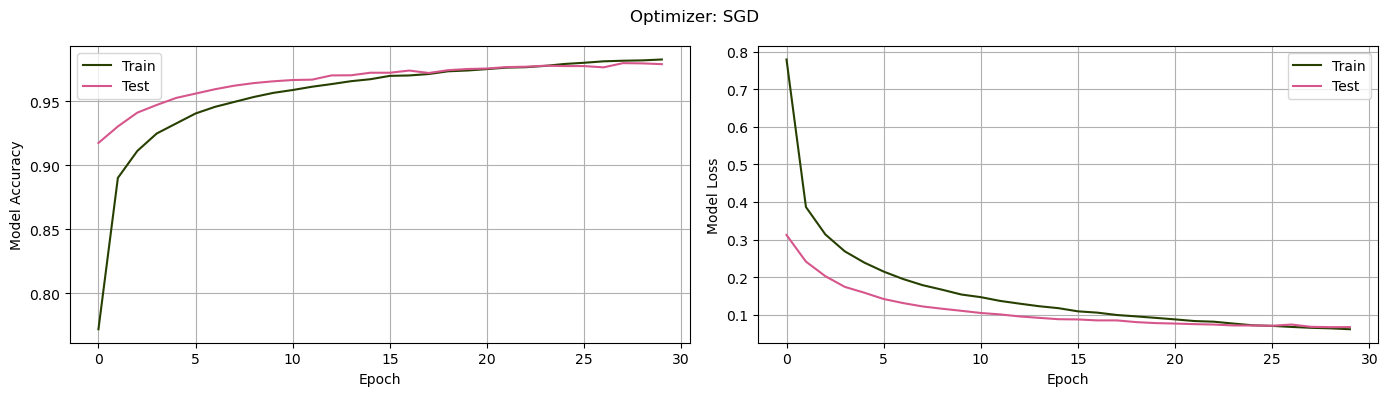

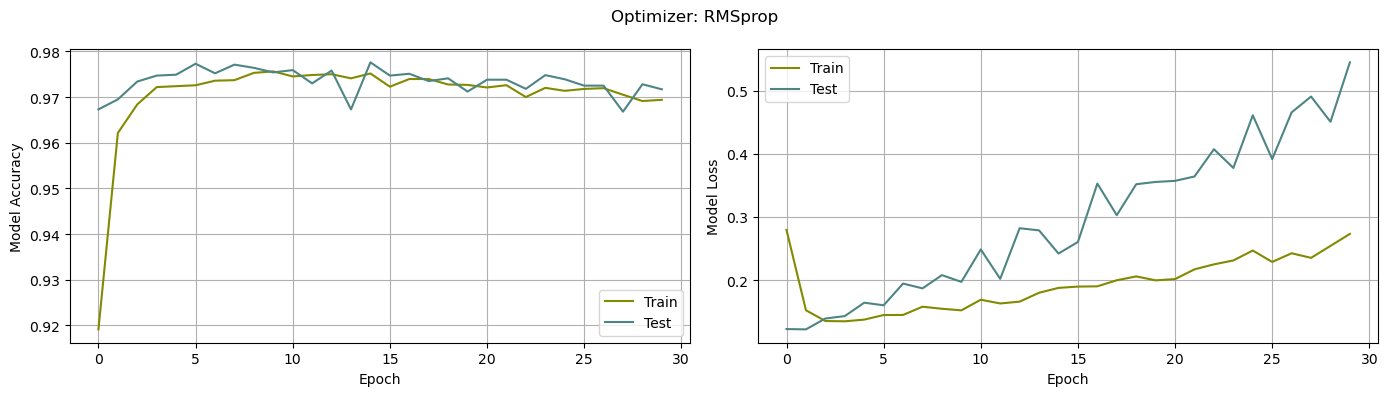

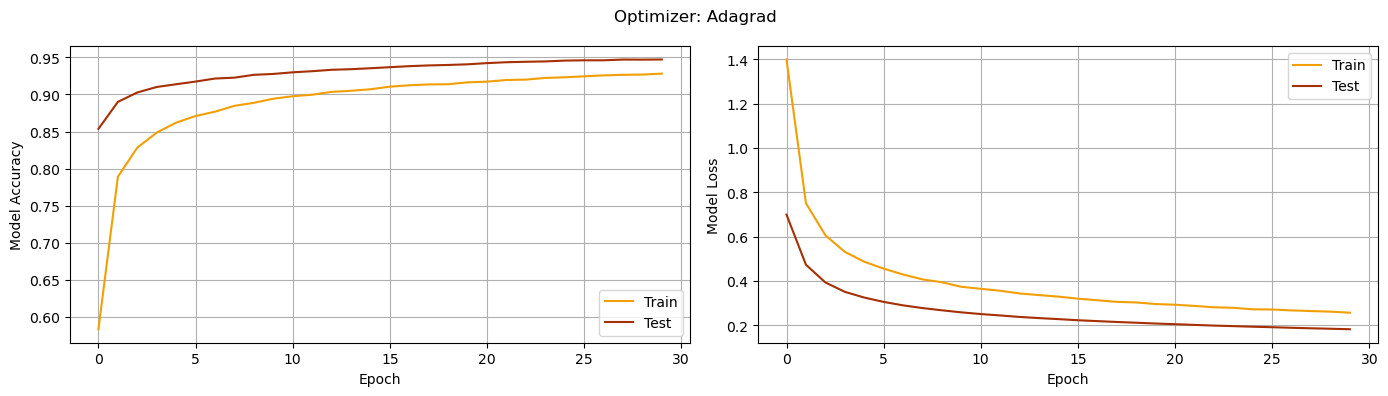

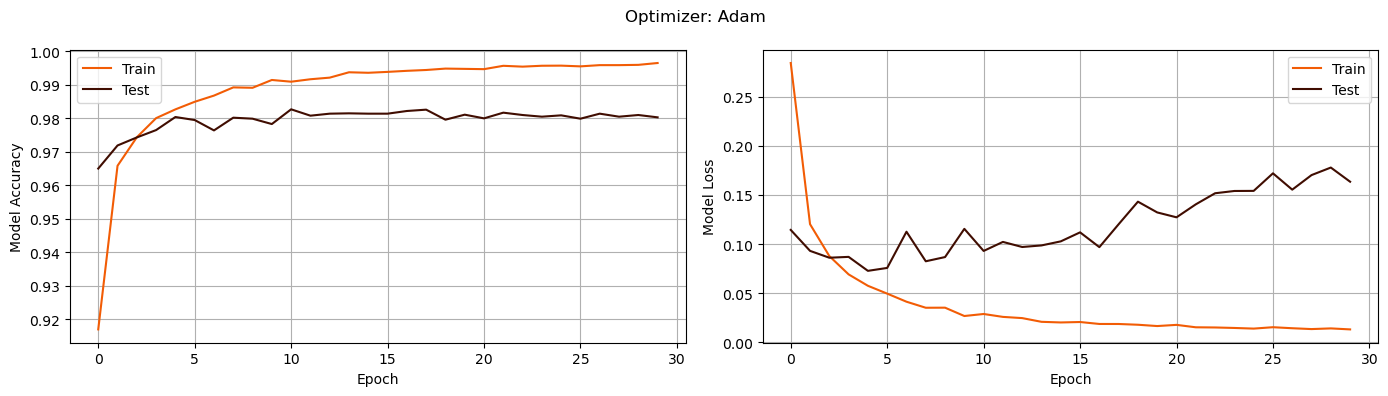

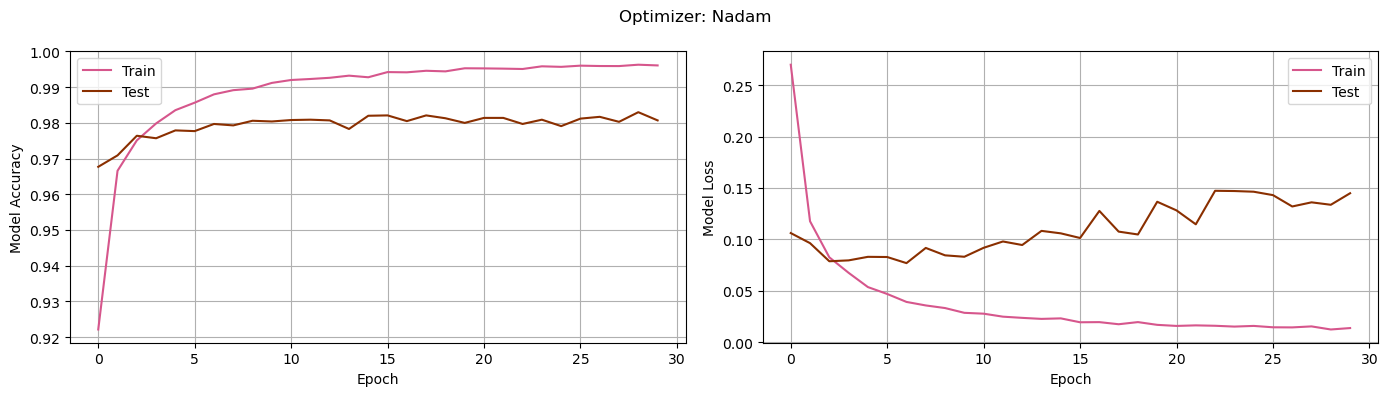

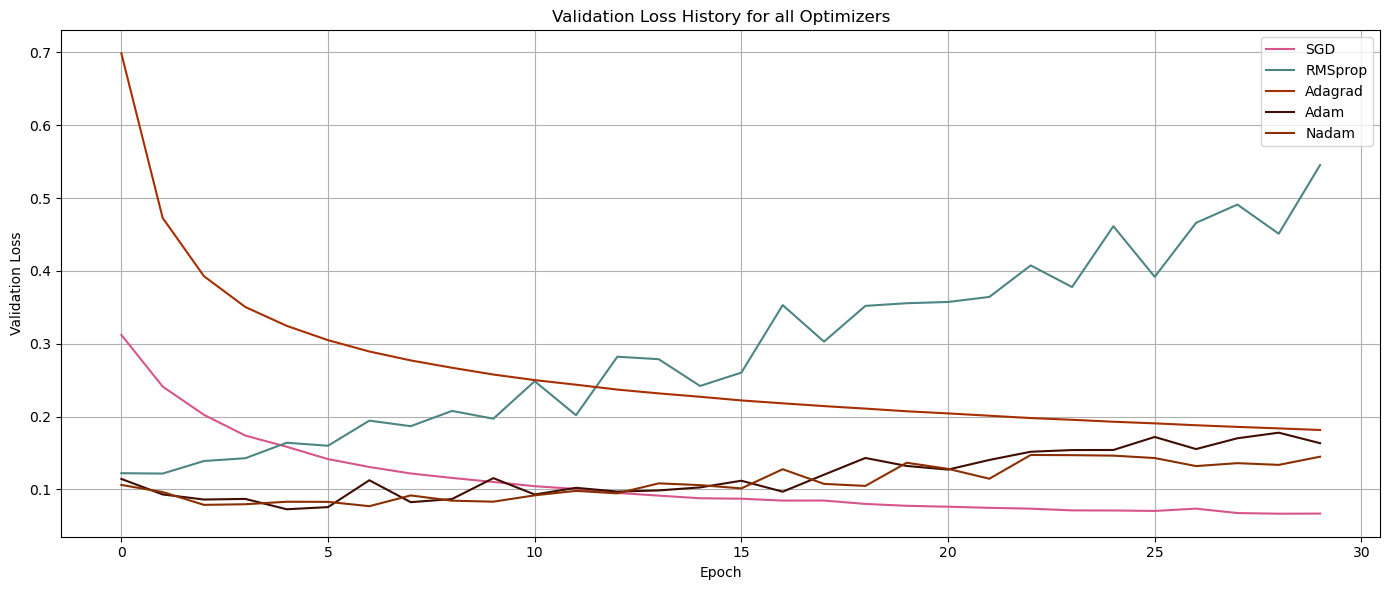

In [55]:
# Training parameters
batch_size = 32
epochs = 30

loss = []
accuracy = []
val_loss_history = []  # To store val_loss for each optimizer

fig_handles = []

# Create the deep neural net
for i in range(len(trial_optimizers)):
	
	model_DNN = compile_model(i)
	# Display the training progress
	print(f"Training model with optimizer {trial_optimizers_names[i]}")
	display_handle = display(display_id=True)

	# Fit the model
	history = model_DNN.fit(X_train, Y_train,
	                        batch_size=batch_size,
	                        epochs=epochs,
	                        verbose=1,
	                        validation_data=(X_test, Y_test))
	# Evaluate the model
	score = model_DNN.evaluate(X_test, Y_test, verbose=1)

	loss.append(score[0])
	accuracy.append(score[1])
	val_loss_history.append(history.history['val_loss'])  # Store val_loss history

	# Plotting training history
	fig, axs = plt.subplots(1, 2, figsize=(14, 4))
	fig.suptitle('Optimizer: ' + trial_optimizers_names[i])

	# Summarize history for accuracy
	axs[0].plot(history.history['acc'], color=colors[i])
	axs[0].plot(history.history['val_acc'], color=colors[i+4])
	axs[0].set_ylabel('Model Accuracy')
	axs[0].set_xlabel('Epoch')
	axs[0].legend(['Train', 'Test'], loc='best')
	axs[0].grid()

	# Summarize history for loss
	axs[1].plot(history.history['loss'], color=colors[i])
	axs[1].plot(history.history['val_loss'], color=colors[i+4])
	axs[1].set_ylabel('Model Loss')
	axs[1].set_xlabel('Epoch')
	axs[1].legend(['Train', 'Test'], loc='best')
	axs[1].grid()
	
	plt.tight_layout()
	fig_handles.append(fig)
      
	# Clear the training progress display
	clear_output(wait=True)

# Display all figures at once
for fig in fig_handles:
   display(fig)

# Prevent matplotlib from displaying figures twice
plt.close('all')

# Plotting validation loss history for each optimizer
fig, ax = plt.subplots(figsize=(14, 6))
for i, opt_name in enumerate(trial_optimizers_names):
    ax.plot(val_loss_history[i], color=colors[i+4], label=opt_name)

ax.set_title('Validation Loss History for all Optimizers')
ax.set_ylabel('Validation Loss')
ax.set_xlabel('Epoch')
ax.legend(loc='best')
ax.grid(True)

plt.tight_layout()
plt.show()

### Results
Looking at the plots obtained from the different optimizers, especially the last one which effectively compares the loss of all the tried optimizers, we can see that the `SGD` optimizer is the one that performs the best. The `Adagrad` together with the `Adam` and `Nadam` optimizers come in second place, reaching a loss pretty close to one another at $30$ epochs, while the `RMSprop` optimizer is by far the worst, for some reason not really converging at all.

<br> It is interesting to note how the weird oscillation of the adam and nadam optimizers could be attributed to overfitting, as in the test-train loss plot, the train loss drops significantly still after $5$ epochs, while the test one starts to increase. This is a clear sign of overfitting.
<br> The SGD and Adagrad optimizers, on the other hand, seem to be the most stable, with train and test loss following each other closely.
<br> The RMSprop optimizer struggles to converge even in training.

These differences amongst optimizers are to be expected, as they are based on different principles and have different hyperparameters. From this study we can see how the choice of the optimizer is crucial in the training of a DNN.

Let us now recompile and train the model with the best optimizer, `SGD`, to show some predictions that we can make with the model.

In [60]:
# recompile and fit the model with the best optimizer to get predictions
# trial_optimizers = [SGD, RMSprop, Adagrad, Adam, Nadam]
best_optimizer = 1

model_DNN = compile_model(best_optimizer)

# Fit the model
history = model_DNN.fit( X_train, Y_train,
                         batch_size=batch_size,
                         epochs=epochs,
                         verbose=1,
                         validation_data=(X_test, Y_test) )
# Evaluate the model
score = model_DNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print()

Epoch 1/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2890 - acc: 0.9165 - val_loss: 0.1753 - val_acc: 0.9558
Epoch 2/30
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1536 - acc: 0.9617 - val_loss: 0.1362 - val_acc: 0.9666
Epoch 3/30
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1435 - acc: 0.9690 - val_loss: 0.1420 - val_acc: 0.9744
Epoch 4/30
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1430 - acc: 0.9711 - val_loss: 0.1501 - val_acc: 0.9737
Epoch 5/30
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1506 - acc: 0.9711 - val_loss: 0.1618 - val_acc: 0.9763
Epoch 6/30
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1426 - acc: 0.9733 - val_loss: 0.1749 - val_acc: 0.9780
Epoch 7/30
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1495 - acc: 0.9718 - val_loss: 0.1992 - val_acc: 0.9760
Epoch 8/30
1875/1875 [==============================] - 3s 2ms

313/313 [==============================] - 0s 542us/step


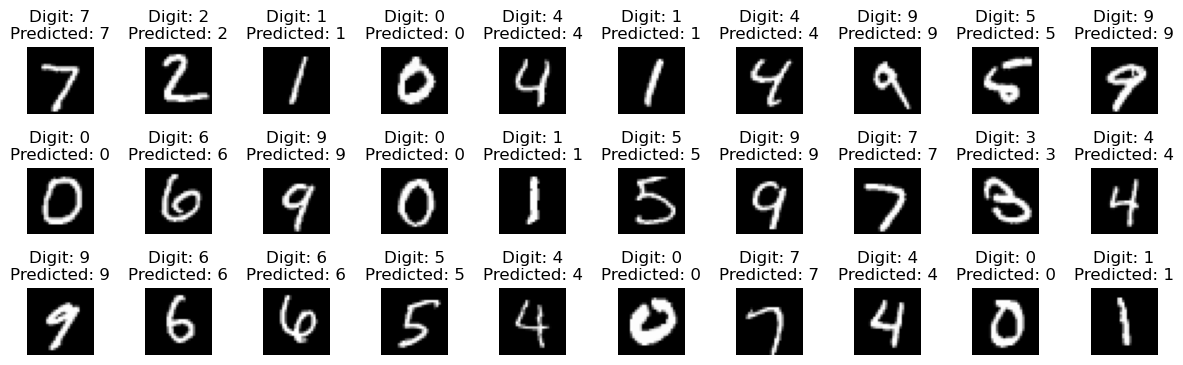

In [61]:
#X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
predictions = model_DNN.predict(X_test)

x_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

plt.figure(figsize = (15,4))

for i in range(30):    
    ax = plt.subplot(3, 10, i + 1)    
    plt.imshow(x_test[i, :, :, 0], cmap = 'gray')    
    plt.title("Digit: {}\nPredicted: {}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))    
    plt.axis('off')
    plt.subplots_adjust(hspace = 0.8)
plt.show()

### Conclusions
After several tests with the five optimizers I have reported above, I conclude that the best results for this specific problem were obtained with the SGD optimizer and a number of epochs greater than $15$. 

In general, with a number of epochs less than 8 the results are not particularly good, with the exception of the cases made with the nadam and adam optimizers, from which excellent results are obtained even after a few epochs. With these two optimizers, however, the model seems to go immediately into overfitting after a few epochs, in fact the graph of the loss for the test set tends to remain constant.